# Multilayer perceptron (MLP)

## Import Libraries and Data Loading

In [46]:
import pandas as pd
import numpy as np
from sklearn.metrics import log_loss, precision_score
from sklearn.model_selection import  GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

train = pd.read_feather('Final_train_dataset.feather')
validation = pd.read_feather('Final_validation_dataset.feather')
test = pd.read_feather('Final_test_dataset.feather')

## Split Data into X(Feature) and Y(Class)

In [47]:
X_train = train.drop(['is_duplicate'],  axis=1)
y_train = train['is_duplicate']
X_val = validation.drop(['is_duplicate'],  axis=1)
y_val = validation['is_duplicate']
X_test = test.drop(['is_duplicate'],  axis=1)
y_test = test['is_duplicate']

## Drop Unecessary Columns (Non Important Features) 

In [48]:
impt_feat = ['freq_q2', 'freq_q1+q2', 'freq_q1', 'jaccard_dist', 'Levenshtein',
       'diff_tfidf_L2', 'diff_tfidf_L1', 'common_ratio', 'levenshtein',
       'fuzz_qratio', 'dist_canberra', 'length_diff', 'lc_substring',
       'lc_subsequence', 'freq_q1-q2', 'same_ending', 'wmdistance',
       'dist_cosine', 'dist_cityblock', 'dist_euclidean', 'dist_minkowski',
       'q1_vec_0', 'q1_vec_1', 'q1_vec_2', 'q1_vec_3', 'q1_vec_4', 'q2_vec_0',
       'q2_vec_1', 'q2_vec_2', 'q2_vec_3', 'q2_vec_4', 'diff_tfidf_L2_norm',
       'q2_word_to_vec', 'total_length']

X_train = X_train[impt_feat]
X_val = X_val[impt_feat]
X_test = X_test[impt_feat]

## Scale Data

In [49]:
sc = StandardScaler()
sc.fit(X_train)
scale = X_train.columns.tolist()

X_train_scaled = X_train.copy()
X_val_scaled = X_val.copy()
X_test_scaled = X_test.copy()
X_train_scaled[scale] = StandardScaler().fit_transform(X_train[scale])
X_val_scaled[scale] = StandardScaler().fit_transform(X_val_scaled[scale])
X_test_scaled[scale] = StandardScaler().fit_transform(X_test_scaled[scale])

## 1. Building Base MLP

In [50]:
mlp = MLPClassifier(max_iter=100, random_state=1)
mlp.fit(X_train_scaled, y_train)

c:\users\65821\appdata\local\programs\python\python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(max_iter=100, random_state=1)

The train log loss is: 0.33766153532405013
The train precision is: 0.8015907605142732
The validation log loss is: 0.3527113990901356
The validation precision is: 0.7997886951928156
The test log loss is: 0.3558854391179202
The test precision is: 0.7793337576914916


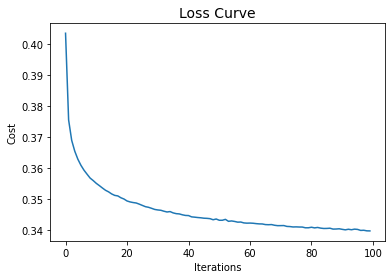

In [51]:
def evaluate(model, x_train, y_train, x_val, y_val, x_test, y_test):
    preds_train = model.predict(x_train)
    preds_prob_train = model.predict_proba(x_train)
    preds_val = model.predict(x_val)
    preds_prob_val = model.predict_proba(x_val)
    preds_test = model.predict(x_test)
    preds_prob_test = model.predict_proba(x_test)
    print("The train log loss is:", log_loss(y_train, preds_prob_train))
    print("The train precision is:", precision_score(y_train, preds_train))
    print("The validation log loss is:", log_loss(y_val, preds_prob_val))
    print("The validation precision is:", precision_score(y_val, preds_val))
    print("The test log loss is:", log_loss(y_test, preds_prob_test))
    print("The test precision is:", precision_score(y_test, preds_test))
    return preds_train, preds_prob_train, preds_val, preds_prob_val, preds_test, preds_prob_test
    
evaluate(mlp, X_train_scaled, y_train, X_val_scaled, y_val, X_test_scaled, y_test)
plt.plot(mlp.loss_curve_)
plt.title("Loss Curve", fontsize=14)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.show()

## 2. Tune Hyperparameter with Grid Search & increase max_iter since optimization hasn't converged yet

In [52]:

parameter_space = {
    'hidden_layer_sizes': [(50,50,50), (150,100,50), (120,80,40)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

mlp = MLPClassifier(max_iter=200)
clf = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=3)
clf.fit(X_train_scaled, y_train)

GridSearchCV(cv=3, estimator=MLPClassifier(), n_jobs=-1,
             param_grid={'activation': ['relu'], 'alpha': [0.05],
                         'hidden_layer_sizes': [(50, 50, 50), (150, 100, 50)],
                         'learning_rate': ['adaptive'], 'solver': ['adam']})

###  Get Best Parameter

In [53]:
print(clf.best_params_)
evaluate(clf, X_train_scaled, y_train, X_val_scaled, y_val, X_test_scaled, y_test)

{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'adaptive', 'solver': 'adam'}
The train log loss is: 0.3396111201205415
The train precision is: 0.8143295686019489
The validation log loss is: 0.35040948273223793
The validation precision is: 0.8110667605854269
The test log loss is: 0.3538137438943744
The test precision is: 0.7938488968130154


### We can see that the above parameters are the optimzed parameters. Lets try increasing the max_iter to increase the predictive power

## 3. Building Final MLP Model

In [54]:
mlp = MLPClassifier(max_iter=500, activation = 'relu', 
                    alpha= 0.05, hidden_layer_sizes= (50, 50, 50), 
                    learning_rate= 'adaptive', solver= 'adam')
mlp.fit(X_train_scaled, y_train)

MLPClassifier(alpha=0.05, hidden_layer_sizes=(50, 50, 50),
              learning_rate='adaptive', max_iter=500)

The train log loss is: 0.3377372338212929
The train precision is: 0.7996299304991425
The validation log loss is: 0.34742364804494874
The validation precision is: 0.8003736920777279
The test log loss is: 0.35068351682614407
The test precision is: 0.784164015553199


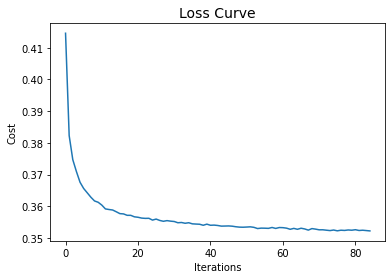

In [60]:
preds_train, preds_prob_train, preds_val, preds_prob_val, preds_test, preds_prob_test = evaluate(mlp, X_train_scaled, y_train, X_val_scaled, y_val, X_test_scaled, y_test)
plt.plot(mlp.loss_curve_)
plt.title("Loss Curve", fontsize=14)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.show()

## We Managed to reduce the validation log loss from 0.35 to 0.347

## Output predicted probabilities for final model 

In [61]:
train_probs_0 = [x[0] for x in preds_prob_train]
test_probs_0 = [x[0] for x in preds_prob_test]

pd.DataFrame(train_probs_0).to_csv('predictions_full_MLP_train.csv', index = False)    
pd.DataFrame(test_probs_0).to_csv('predictions_full_MLP_test.csv', index = False)